<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Challenge" data-toc-modified-id="Challenge-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Challenge</a></span></li><li><span><a href="#Workstation-Configuration" data-toc-modified-id="Workstation-Configuration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Workstation Configuration</a></span></li><li><span><a href="#Model-Validation:-Plant-Model" data-toc-modified-id="Model-Validation:-Plant-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><em>Model Validation:</em> Plant Model</a></span><ul class="toc-item"><li><span><a href="#PD-Control-of-Position" data-toc-modified-id="PD-Control-of-Position-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>PD Control of Position</a></span></li></ul></li><li><span><a href="#Controller-Design:-Angle-Deficiency-for-PD-Controller" data-toc-modified-id="Controller-Design:-Angle-Deficiency-for-PD-Controller-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><em>Controller Design:</em> Angle Deficiency for PD Controller</a></span><ul class="toc-item"><li><span><a href="#PD-control-Arduino-Update" data-toc-modified-id="PD-control-Arduino-Update-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>PD control Arduino Update</a></span></li></ul></li><li><span><a href="#Controller-Validation:-PD-Control-of-Motor-Shaft-Load" data-toc-modified-id="Controller-Validation:-PD-Control-of-Motor-Shaft-Load-5"><span class="toc-item-num">5&nbsp;&nbsp;</span><em>Controller Validation:</em> PD Control of Motor-Shaft-Load</a></span></li></ul></div>

# Challenge

You will design a controller for motor position using your *complete toolkit* of root locus analysis tools.  This will require you to implement new hardware capability to read the motor position using encoders (just like the zumo).  You will use the plant transfer function you developed for the **MOTOR-SHAFT-LOAD** configuration to achieve $\zeta = 0.5$  $\omega_n = 25 rad/s$ for the dominant eigenvalue pair.  


# Workstation Configuration

For this lab, you will be using the motor connected to the load inertia via a RIGID shaft. You have a choice of achieving this by installing your long shaft as you have in past labs, or by simply replacing the spring coupler with the rigid brass coupler, as shown below. If you have any questions or concerns, please contact your instructor.

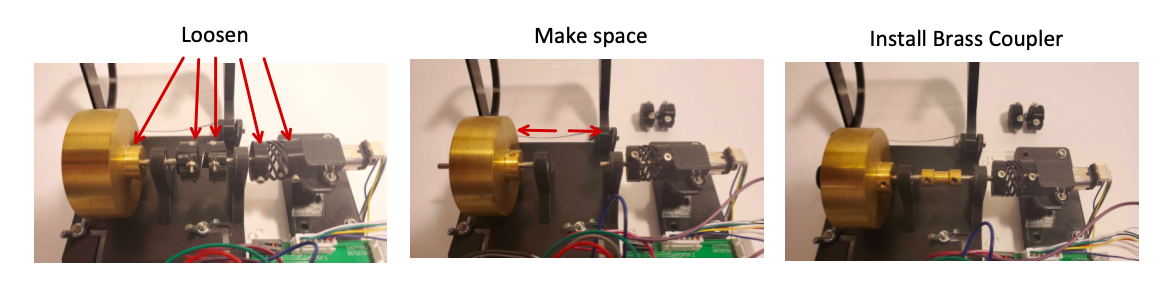

# *Model Validation:* Plant Model

**Begin by including the validation of your plant model for *velocity* for the motor-rigid shaft-load configuration in the code block below. If it fits well, you can use the FIRST ORDER portion of your motor-spring shaft-load model from Lab 5, or you can generate a new plant model if the fit is not accurate.  Include in your OUTPUT a graph of your fit to data and display the plant transfer function.**

omega0_load =  25.349
omegass_load =  50.763
tau_load =  0.16800
a =  5.9522
A =  66.637

Transfer function 'GH_load1' from input 'u1' to output ...

        66.64  
 y1:  ---------
      s + 5.952

Continuous-time model.


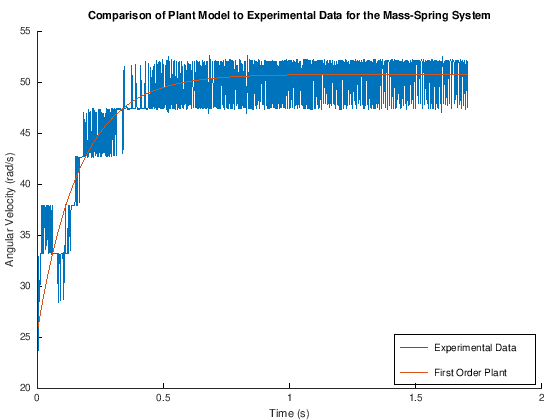

In [1]:
% loading data...
data_load = load('StepResponse_Weighted8.txt');
time_load = data_load(:,1)*10^-6; % time (s)
Vs_load = data_load(:,3); % voltages (V)
V0_load = Vs_load(1); % initial voltage (V)
startIndex_load = find(Vs_load>V0_load,1,'first'); % finding index where votlage step occurs
tstart_load = time_load(startIndex_load); % time where voltage step occurs
Vin_load = Vs_load(startIndex_load); % magnitude of input voltage after step (V)
omega_load = data_load(:,4); % angular speed (rad/s)
omega0_load = mean(omega_load(1:20)) % initial angular speed (rad/s)
omegass_load = mean(omega_load(end-20:end)) % steady state angular speed after voltage step (rad/s)
omega_trimmed = omega_load(startIndex_load:end); % trimmed angular speeds to only include after the voltage step
time_trimmed = time_load(startIndex_load:end)-tstart_load; % trimmed time to only include after the voltage step

% finding time constant (tau)
omegatau_load = (0.632*(omegass_load - omega0_load))+omega0_load; 
tau_load = time_load(find(omega_load<omegatau_load,1,'last'))-tstart_load 
a = 1/tau_load
A = ((omegass_load-omega0_load)*a)/(Vin_load-V0_load)

% plotting model against experimental data...
s = tf('s');
GH_load1 = A/(s+a) % first order piece of third order system
[ysim_load1,tsim_load1]=step(GH_load1,time_trimmed);
ymodel_load1 = ((Vin_load-V0_load)*ysim_load1)+omega0_load;

figure
hold on;
plot(time_load(startIndex_load:end)-tstart_load,omega_load(startIndex_load:end))
plot(tsim_load1,ymodel_load1)
title('Comparison of Plant Model to Experimental Data for the Mass-Spring System')
xlabel('Time (s)')
ylabel('Angular Velocity (rad/s)')
legend('Experimental Data','First Order Plant','location','southeast')
hold off;

## PD Control of Position

Although you previously developed a plant transfer function with angular velocity as the output, you can modify the velocity transfer function so that it outputs position simply by adding an integrator in cascade.  The block diagram for PD control of your velocity transfer function modified with an integrator is shown below.

Notice that $H = 1$ in the diagram.  This implies you will be able to directly measure the position of the motor shaft.  The method to accomplish this is described below.

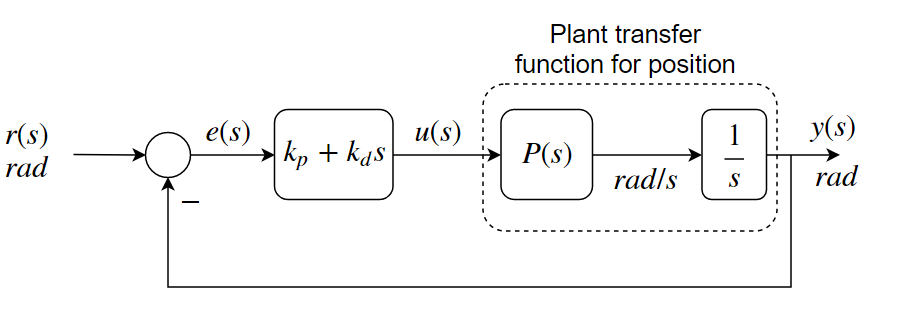

# *Controller Design:* Angle Deficiency for PD Controller

Using the angle deficiency method, design a PD controller for **position** that has the following characteristics: $\zeta = 0.5$  $\omega_n = 25 rad/s$. You may assume that the summing gain, $K_{sum}$, that is often included in a root-locus based control design, is $1$. This way, if you implement a summing gain in your controller, you'll have the freedome to use it to "walk around" the root locus from your original design goal if needed.

Perform the *entire* calculation in the code block below. Include in your output
* A root locus plot that shows your target eigenvalue location and that the designed root locus passes throught that point
* Dislay in the code *output* the gain, $K$, from the root locus plot 
* Calculate and *output* your controller gains $k_p$, $k_d$, and $k_{sum}$ 
</font>


Transfer function 'P' from input 'u1' to output ...

          66.64    
 y1:  -------------
      s^2 + 5.952 s

Continuous-time model.
sd1 = -12.500 + 21.651i
z =  32.812

Transfer function 'P_PD' from input 'u1' to output ...

      66.64 s + 2187
 y1:  --------------
      s^2 + 5.952 s 

Continuous-time model.
                                                                               
                                       Root Locus of PPD                       
                                                                               
                   |&         &          &         &          &         &      
                30 |&+&&&&&&&&&&&&&&&&&&&&&&&&&&&&&+-----------$$$$$$-----+&   
                   |&         &          &         |###?###loc$$    $$    |    
                20 |&+&&&&&&&&&&&&&&&&&&&&&&&&&&&&&|   B   open loop poles|&   
                   |&         &          &         +---F---zeros------$$--+    
                   |&         &          &

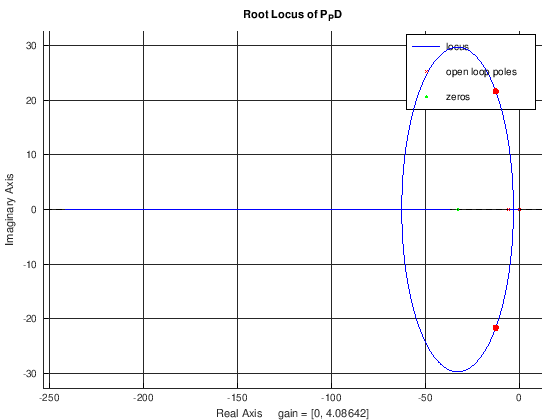

In [5]:
P = (A/(s+a))*(1/s) % plant transfer function for position
zeta = 0.5;
wn = 25;
% desired eigenvalues...
sd1 = -zeta*wn + wn*sqrt(1-zeta^2)*j 
sd2 = -zeta*wn - wn*sqrt(1-zeta^2)*j; 

% finding zero added from PD control using angle deficiency...
angle_p1 = atan2d(wn*sqrt(1-zeta^2),-zeta*wn); % angle from pole at origin to target eigenvalue
angle_p2 = atan2d(wn*sqrt(1-zeta^2),-zeta*wn+a); % angle from pole at a to target eigenvalue
angle_z = -180+angle_p1+angle_p2; % angle from zeroto target eigenvalue
d = (wn*sqrt(1-zeta^2))/(tand(angle_z));
z = zeta*wn + d % zero

P_PD = P*(s+z) % transfer function under PD control

% plotting root locus
figure()
hold on;
rlocus(P_PD)
plot(real(sd1),imag(sd1),'r.','MarkerSize',15)
plot(real(sd2),imag(sd2),'r.','MarkerSize',15)
hold off;

In [16]:
% finding the gain (K) using magnitude criterion...
sd = -sd2;
Pmag_sd = abs((A*(sd+z))/(sd*(sd+a)));
K_PD = 1/Pmag_sd
Ksum_PD = 1.0;
Kp_PD = K_PD/Ksum_PD
Kd_PD = Kp_PD*z

K_PD =  0.21252
Kp_PD =  0.21252
Kd_PD =  6.9731


##  PD control Arduino Update

You will need to add the derivative of the error to your control law to implement PD control

$ u=k_{sum}(k_p e+k_d \frac{de}{dt})$ 

Like you did with the integrator, you will need to determine a numerical approximation of the derivative that gets updated each time through the void loop() function of your Arduino code.  The simplest approximation of a derivative is given by:

$\large \frac{de}{dt} \sim \frac{e_i - e_{i-1}}{t_i - t_{i-1}}$


You will also need to update the code to reflect your closed loop system now that you are using angular positon as an input and output.
* Update the initial input and step input to reflect that you are asking for a position in radians
* Update the calculation of system output to reflect it is now angular position in radians

<font color = "red">
BEFORE running your controller, test that the direction of your measured angular position is compatible with your control signal.  That is, as the motor is turned from the desired position, the control signal should be driving the motor <b>BACK</b> to the desired position.  Adjust the sign of the theta value to ensure you have negative feedback.
</font>

<font color = "blue">
Include in the cell below a copy of your completed Arduino code. Double-click on this cell to see how to properly format your code as shown below:

```c
//sample Arduino code
//properly formated for display
```

</font>

```javascript
//SSR_SWITCH represents the Stop/Safe/Ready switch connected to pin 23
//R1 represents the RUN1 BUT1ton connected to pin 25
//R2 represents the RUN1 BUT1ton connected to pin 25
//E_STOP represents the emergency stop BUT1ton connected to pin 4
//RWG_LED represents the ready/warning green LED connected to pin 41
//RWR_LED represents the ready/warning green LED connected to pin 39
//RFB_LED represents the run/fault blue LED connected to pin 43
//RFR_LED represents the run/fault red LED connected to pin 45
//MOTOR2_A represents motor 2 direction A connected to pin 6
//MOTOR2_B represents motor 2 direction B connected to pin 7
//MOTOR2_PWM represents motor 2 PWM connected to pin 8
//RELAY represents the motor relay connected to pin 37
//P1 represents potentiometer 1 connected to pin A0
//P2 represents potentiometer 2 connected to pin A1
//BUT1 represents button 1 connected to pin 29
//encoderChAPin represents channel A for the encoder connected to pin 20
//encoderChBPin represents channel B for the encoder connected to pin 21

//SWITCH represents the Stop/Safe/Ready switch reading (0 when in the ready position and 1 when in the safe/stop position)
//RUN1 represents the RUN1 BUT1ton reading (0 when pressed and 1 when not pressed)
//RUN2 represents the RUN1 BUT1ton reading (0 when pressed and 1 when not pressed)
//ESTOP represents the emergency stop BUT1ton reading (0 when pressed and 1 when not pressed)
//BTN1 represents the button 1 reading (0 when pressed and 1 when not pressed)
//POT1 represents the first potentiometer's reading (0-1021)
//POT2 represents the second potentiometer's reading (0-1021)

//SAFE represents the safe state
//FAULT represents the fault state
//READY represents the ready state
//WARNING represents the warning state
//RUNNING represents the running state

//safeToReady represents the transition from the safe to ready state
//readyToWarning represents the transition from the ready to the warning state
//warningLatch represents the latch on the warning state
//warningToRunning represents the transition from the warning to the running state
//warningToReady represents the transition from the warning to the ready state
//safeToFault represents the transition from the safe to the fault state
//readyToFault represents the transition from the ready to the fault state
//warningToFault represents the transition from the warning to the fault state
//runningToFault represents the transition from the running to the fault state
//faultToSafe represents the transition from the fault to the safe state
//readyToSafe represents the transition from the ready to the safe state
//warningToSafe represents the transition from the warning to the safe state
//runningToSafe represents the transition from the running to the safe state
//safeLatch represents the latch on the safe state
//faultLatch represents the latch on the fault state
//readyLatch represents the latch on the ready state
//runningLatch represents the latch on the running state

//TMR1 represents the timer and will return true if the time duration is exceeded
//SWITCH_OLD represents the last state of the stop/safe/ready switch
//ledState represents the state of the LED
//previousMillis represents the last time LED was updated
//interval represents the interval at which to blink the LED (milliseconds)
//desiredPosition represents the desired speed of the motor (determined from potentiometer settings)
//inputVoltage represents the voltage being sent to the motor to produce the desired speed
//Kp represents the proportional gain value determined from controller design
//Ksum represents the sum gain value determined from controller design (assumed to be 1)
//Kd represents the derivative gain value determined from controller design
//encoderCountShared represents the encoder count from both channels
//motorPosition represents the current motor position in radians
//pastPosition represents the motor's past position in radians
//pastTime represents the previous time in microseconds
//timeElapsed represents the elapsed time between motor position measurements in microseconds
//POT1_pos represents the position setting from the first potentiometer (0-45 rad/s)
//POT2_pos represents the position setting from the second potentiometer (-45 to 45 rad/s)
//motor_count represents the count value being written to the motor (0-255)
//error represents the error between the desired and actual motor positions
//derivativeOfError represents the current derivative of error 
//pastError represents the past error value from the most recent loop
//delta_t represents the change in time between loop passes

#include <LiquidCrystal.h> //include LCD library

//initializing input and output pins
const int SSR_SWITCH = 23;
const int R1 = 25;
const int R2 = 27;
const int E_STOP = 4;
const int RWG_LED = 41;
const int RWR_LED = 39;
const int RFB_LED = 43;
const int RFR_LED = 45;
const int MOTOR1_PWM = 46;
const int MOTOR1_DIR = 48;
const int RELAY = 37;
const int P1 = A0;
const int P2 = A1;
const int BUT1 = 29;
int encoderChAPin = 2;   //Channel A pin for the encoder
int encoderChBPin = 3;   //Channel B pin for the encoder

// Pin numbers for LDC display
int lcd_rs_pin = 14;
int lcd_en_pin = 15;
int lcd_db4_pin = 16;
int lcd_db5_pin = 17;
int lcd_db6_pin = 18;
int lcd_db7_pin = 19;

//initializing states
bool SAFE = false;
bool FAULT = true;
bool READY = false;
bool WARNING = false;
bool RUNNING = false;

// initializing transitions
bool safeToReady = false;
bool readyToWarning = false;
bool warningLatch = false;
bool warningToRunning = false;
bool warningToReady = false;
bool safeToFault = false;
bool readyToFault = false;
bool warningToFault = false;
bool runningToFault = false;
bool faultToSafe = false;
bool readyToSafe = false;
bool warningToSafe = false;
bool runningToSafe = false;
bool safeLatch = false;
bool faultLatch = false;
bool readyLatch = false;
bool runningLatch = false;

// initializing miscellaneous variables
bool TMR1 = false;
bool SWITCH_OLD = true;
int ledState = LOW;
unsigned long previousMillis = 0;
const long interval = 250;
float desiredPosition;
float inputVoltage;
float Kd = 6.9731;
float Ksum = 1;
float Kp = 0.21252;
volatile long encoderCountShared;
float motorPosition;
float pastPosition;
unsigned long pastTime = 0;
float timeElapsed = 0;
float POT1_pos = 0;
float POT2_pos = 0;
float motor_count = 0;
float derivativeOfError;
float pastError;
float error;
float delta_t;

LiquidCrystal LCD(lcd_rs_pin, lcd_en_pin, lcd_db4_pin, lcd_db5_pin, lcd_db6_pin, lcd_db7_pin);

void setup() {
  LCD.begin(8, 2); // initialize LCD
  Serial.begin(115200);
  pinMode(SSR_SWITCH, INPUT);
  pinMode(R1, INPUT_PULLUP);
  pinMode(R2, INPUT_PULLUP);
  pinMode(E_STOP, INPUT_PULLUP);
  pinMode(RWG_LED, OUTPUT);
  pinMode(RWR_LED, OUTPUT);
  pinMode(RFB_LED, OUTPUT);
  pinMode(RFR_LED, OUTPUT);
  pinMode(RELAY, OUTPUT);
  pinMode(P1, INPUT);
  pinMode(P2, INPUT);
  pinMode(BUT1, INPUT_PULLUP);

  //encoder
  attachInterrupt(digitalPinToInterrupt(encoderChAPin), EncoderChA, CHANGE);
  attachInterrupt(digitalPinToInterrupt(encoderChBPin), EncoderChB, CHANGE);
}

void loop() {
  noInterrupts();  //stop the interrupt system so the value doesn't change mid interrupt
  long encoderCount = encoderCountShared; //save the count value to a local variable
  interrupts();    //restart the interrupt system
  unsigned long currentMillis = millis(); //defining current time
  unsigned long currentTime = micros();

  // BLOCK 1: Process Inputs
  //----------------------------------------
  int SWITCH = digitalRead(SSR_SWITCH);
  int RUN1 = !digitalRead(R1); //negating so that this variable is 1 when pressed
  int RUN2 = !digitalRead(R2); //negating so that this variable is 1 when pressed
  int ESTOP = !digitalRead(E_STOP); //negating so that this variable is 1 when pressed
  int BTN1 = !digitalRead(BUT1); //negating so that this variable is 1 when pressed
  int POT1 = analogRead(P1);
  int POT2 = analogRead(P2);

  //call timer
  TMR1 = Timer(RUN1 && RUN2, 2000);

  // BLOCK 2: State Transition Logic
  //----------------------------------------
  safeToReady = SAFE && !SWITCH;
  readyToWarning = READY && RUN1 && RUN2;
  warningLatch = WARNING && !TMR1 && RUN1 && RUN2 && !SWITCH && !ESTOP;
  warningToRunning = WARNING && TMR1 && RUN1 && RUN2;
  warningToReady = WARNING && !TMR1 && !RUN1 || WARNING && !TMR1 && !RUN2;
  safeToFault = SAFE && ESTOP;
  readyToFault = READY && ESTOP;
  warningToFault = WARNING && ESTOP;
  runningToFault = RUNNING && ESTOP;
  faultToSafe = FAULT && !ESTOP && SWITCH && !SWITCH_OLD;
  readyToSafe = READY && SWITCH && !ESTOP;
  warningToSafe = WARNING && SWITCH && !ESTOP;
  runningToSafe = RUNNING && SWITCH && !ESTOP;
  safeLatch = SAFE && SWITCH && !ESTOP;
  faultLatch = FAULT && ESTOP || FAULT && !SWITCH || FAULT && SWITCH_OLD;
  readyLatch = READY && !RUN1 && !ESTOP && !SWITCH || READY && !RUN2 && !ESTOP && !SWITCH;
  runningLatch = RUNNING && !ESTOP && !SWITCH;

  // BLOCK 3: Update States
  //----------------------------------------
  SAFE = faultToSafe || readyToSafe || warningToSafe || runningToSafe || safeLatch;
  FAULT = safeToFault || readyToFault || warningToFault || runningToFault || faultLatch;
  READY = safeToReady || warningToReady || readyLatch;
  WARNING = readyToWarning || warningLatch;
  RUNNING = warningToRunning || runningLatch;

  // BLOCK 4: Set Outputs and Old Variables
  //----------------------------------------

  if (BTN1 == 1) { // if button 1 is pressed...
    desiredPosition = POT1_pos + POT2_pos;
  } else {
    desiredPosition = POT1_pos;
  }

  // making sure desired speed is not greater than 45 rad/s nor smaller than 0 rad/s
  if (desiredPosition > 360.0) {
    desiredPosition = 360.0;
  } else if (desiredPosition < 0.0) {
    desiredPosition = 0.0;
  }

  if (SAFE == 1) {
    digitalWrite(RELAY, LOW);
    digitalWrite(MOTOR1_PWM, LOW);
    digitalWrite(MOTOR1_DIR, LOW);

    //READY/WARNING LED illuminated green
    digitalWrite(RFR_LED, LOW);
    digitalWrite(RWR_LED, LOW);
    digitalWrite(RFB_LED, LOW);
    digitalWrite(RWG_LED, HIGH);

    // POT values
    POT1_pos = POT1 * (360.0 / 1021.0);
    POT2_pos = POT2 * (360.0 / 1021.0);

    // printing to LCD
    LCD.clear();
    LCD.print("P1: ");
    LCD.print(POT1_pos);
    LCD.setCursor(0, 2);
    LCD.print("P2: ");
    LCD.print(POT2_pos);

  }

  if (FAULT == 1) {
    digitalWrite(RELAY, LOW);
    digitalWrite(MOTOR1_PWM, LOW);
    digitalWrite(MOTOR1_DIR, LOW);

    //RUN/FAULT LED flashing red and all other LEDs switched off
    if (currentMillis - previousMillis >= interval) {
      previousMillis = currentMillis;
      if (ledState == LOW) {
        ledState = HIGH;
      } else {
        ledState = LOW;
      }
    }

    digitalWrite(RWG_LED, LOW);
    digitalWrite(RWR_LED, LOW);
    digitalWrite(RFB_LED, LOW);
    digitalWrite(RFR_LED, ledState);

    // printing to LCD
    LCD.clear();
    LCD.print("FAULT");
  }

  if (READY == 1) {
    digitalWrite(RELAY, LOW);
    digitalWrite(MOTOR1_PWM, LOW);
    digitalWrite(MOTOR1_DIR, LOW);

    //READY/WARNING LED flashing green and all other LEDs switched off
    if (currentMillis - previousMillis >= interval) {
      previousMillis = currentMillis;
      if (ledState == LOW) {
        ledState = HIGH;
      } else {
        ledState = LOW;
      }
    }
    digitalWrite(RWR_LED, LOW);
    digitalWrite(RFB_LED, LOW);
    digitalWrite(RFR_LED, LOW);
    digitalWrite(RWG_LED, ledState);
  }

  if (WARNING == 1) {
    digitalWrite(RELAY, LOW);
    digitalWrite(MOTOR1_PWM, LOW);
    digitalWrite(MOTOR1_DIR, LOW);

    //READY/WARNING LED flashing red and all other LEDs switched off
    if (currentMillis - previousMillis >= interval) {
      previousMillis = currentMillis;
      if (ledState == LOW) {
        ledState = HIGH;
      } else {
        ledState = LOW;
      }
    }

    digitalWrite(RWG_LED, LOW);
    digitalWrite(RFR_LED, LOW);
    digitalWrite(RFB_LED, LOW);
    digitalWrite(RWR_LED, ledState);
  }

  if (warningToRunning == 1){
    long startTime = micros();
  }

  if (RUNNING == 1) {
    //calculating actual motor speed
    motorPosition = encoderCount * (PI / 300) * (180.0/PI);
    if (motorPosition > 360.0){
      float factor = floor(motorPosition/360.0);
      motorPosition = motorPosition - factor*360.0;
    }
    timeElapsed = ((currentTime - pastTime) * 1E-6);
    
    //determining error between desired and actual speed and computing input voltage
    error = desiredPosition - motorPosition;
    delta_t = (micros()-pastTime);
    derivativeOfError = (error - pastError)/(delta_t);
    inputVoltage = Ksum*(Kp*error + Kd*derivativeOfError);
    if (inputVoltage < 0.0){
      digitalWrite(MOTOR1_DIR, HIGH);
      inputVoltage = -inputVoltage;
    } else {
      digitalWrite(MOTOR1_DIR, LOW);
    }
    
    if (inputVoltage > 5.0) {
      inputVoltage = 5.0;
    }
    motor_count = inputVoltage / 5 * 255;
    digitalWrite(RELAY, HIGH);
    analogWrite(MOTOR1_PWM, motor_count);

    //RUN/FAULT LED illuminated blue
    digitalWrite(RWG_LED, LOW);
    digitalWrite(RWR_LED, LOW);
    digitalWrite(RFR_LED, LOW);
    digitalWrite(RFB_LED, HIGH);

    //printing to Serial monitor...
    Serial.print(micros());
    Serial.print("\t");
    Serial.print(desiredPosition);
    Serial.print("\t");
    Serial.print(motorPosition);
    Serial.print("\t");
    Serial.print(motor_count);
    Serial.print("\t");
    Serial.print(inputVoltage); 
  }

  // setting "old" variables
  SWITCH_OLD = SWITCH;
  pastTime = currentTime;
  pastPosition = motorPosition;
  pastError = error;

  Serial.println();
}
```

# *Controller Validation:* PD Control of Motor-Shaft-Load

* After modifying the arduino code and inputting your calculated gains, run the motor with the rigid shaft and load.
* Set the position step such that the pwm output signal is ALWAYS ***LESS THAN*** 255 counts. If this maximum is reached then the system will have non-linear characteristics that are not included in your model.
* Record the response to your step input by outputting the position and other relevant paremeters to the serial monitor.  By cutting and pasting from the serial monitor or using realterm, save the data to a .txt file. 

<font color="blue"> In the MATLAB cell below, compare the data to the predicted response in a single plot. </font>


Transfer function 'Gcl' from input 'u1' to output ...

          14.16 s^3 + 549 s^2 + 2766 s    
 y1:  ------------------------------------
      s^4 + 26.07 s^3 + 584.4 s^2 + 2766 s

Continuous-time model.


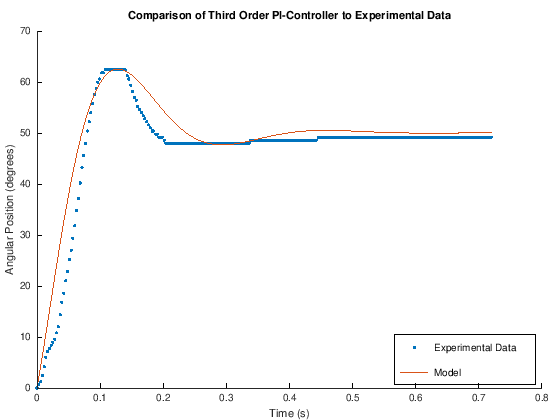

In [17]:
data_CL = load('StepResponse_CLPosition2.txt');
time_CL = data_CL(:,1)*1E-6; % time (s)
thetad_CL = data_CL(:,2); %  desired angular position (degrees)
theta_CL = data_CL(:,3); % actual angular position (degrees)
theta0_CL = theta_CL(1); % initial angular position (degrees)
thetass_CL = mean(theta_CL(end-50:end)); % steady state angular position (degrees)
PWM_CL = data_CL(:,4); % PWM signal (counts)
voltage_CL = data_CL(:,5); % input voltage (V)
thetad0_CL = thetad_CL(1); % initial desired angular position (degrees)
startIndex = find(thetad_CL>thetad0_CL,1,'first'); % index where step is applied
thetadss_CL = thetad_CL(startIndex); % steady state desired angular position magnitude (degrees)
desiredPosition = thetadss_CL - thetad0_CL; % step magnitude (degrees)
tstart = time_CL(startIndex); % time where step is applied (s)
timetrimmed = time_CL(startIndex:end) - tstart;
thetatrimmed = theta_CL(startIndex:end);

% first order PI Controller model...
H = 1;
C = Ksum_PD*Kp_PD;
Gcl = (C*P_PD)/(1+C*P_PD*H)
[y,t]=step(Gcl,timetrimmed);
ymodel = (desiredPosition*y)+thetad0_CL;

figure()
hold on;
plot(timetrimmed,thetatrimmed,'.')
plot(t,ymodel)
title('Comparison of Third Order PI-Controller to Experimental Data')
xlabel('Time (s)')
ylabel('Angular Position (degrees)')
legend('Experimental Data','Model','location','southeast')
hold off;

In the cell below, summarize the comparison of simulation and data.  Considering the behaviors you have seen with this electromechanical system and tried to model, describe any discrepencies and your best understanding of their source OR questions you have about them.

Overall, for this step size (of $50^{\circ}$), the model fits the data accurately. The amount of overshoot as well as general rise and settling time is basically identical between both the experimental data and the PD controller model. However, if the step size were to be increased, discrepancies between the experimental data and the model would begin to become more prominent. This is due to the physical limitations with the lab rig. A maximum limit of input voltages was set to 5V, as that is what this current setup is capable of producing. Thus, if the calculated input voltage based on the error between actual and desired angular position is greater than 5V, the FSM limits the voltage sent to the motor to be 5V. However, for the model, this limitation on input voltage does not exist. Thus, the model will predict that the input voltage being sent to the motor is strictly based on the error calculation, even if this is greater than 5V. Thus, with larger step sizes (where the error will be larger in the beginning starting from rest), this discrepancy between the model and the experimental data will be significantly more pronounced. In this case, the model would have a significantly quicker rise and settling time in comparison to the experimental data. Therefore, due to physical limitations, this model is only accurate for smaller step sizes. 